<a href="https://colab.research.google.com/github/dinianggraini13/SKRIPSI/blob/main/IMPLEMENTASI_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = "gdrive/MyDrive/"

Mounted at /content/gdrive


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('hasilreviews.csv')

In [4]:
df.head

<bound method NDFrame.head of                                                  content  score
0      I literally can't use the app. It won't let me...      1
1      The platform has potential, but the app, which...      3
2      Pretty good for a first launch!! Its easy to u...      3
3      Currently, it's very challenging to use. It's ...      2
4      Meh. Not the greatest experience on a Chromebo...      2
...                                                  ...    ...
34463                                 Confusing timeline      2
34464                                     So far so good      5
34465                                    Very impressive      5
34466              Keeps crashing when i attach a photo.      1
34467  ❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️...      5

[34468 rows x 2 columns]>

### **LABELING**

In [7]:
# Membuat kolom baru 'label' berdasarkan nilai score
df['label'] = df['score'].apply(lambda x: 'positif' if x in [4, 5] else ('netral' if x == 3 else 'negatif'))

# Menampilkan hasil
print(df.head())

# Menyimpan dataset yang telah dilabeli
df.to_csv('hasilreviews_label.csv', index=False)  # Ganti 'hasilreviews_labeled.csv' dengan nama file keluaran yang diinginkan

                                             content  score    label
0  I literally can't use the app. It won't let me...      1  negatif
1  The platform has potential, but the app, which...      3   netral
2  Pretty good for a first launch!! Its easy to u...      3   netral
3  Currently, it's very challenging to use. It's ...      2  negatif
4  Meh. Not the greatest experience on a Chromebo...      2  negatif


In [10]:
# Hanya menyimpan kolom 'label' dan 'content'
df = df[['content', 'label']]

df.head()

,content,label
0,I literally can't use the app. It won't let me...,negatif
1,"The platform has potential, but the app, which...",netral
2,Pretty good for a first launch!! Its easy to u...,netral
3,"Currently, it's very challenging to use. It's ...",negatif
4,Meh. Not the greatest experience on a Chromebo...,negatif


In [12]:
# Menghitung total masing-masing label

df.label.value_counts()

negatif    16296
positif    15026
netral      3146
Name: label, dtype: int64

In [13]:
# Membuat kode unik dari kolom label

possible_labels = df.label.unique()

In [14]:
# Mengonversi label ke kelas index

label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [15]:
df['label'] = df.label.replace(label_dict)

In [16]:
df.head()

,content,label
0,I literally can't use the app. It won't let me...,0
1,"The platform has potential, but the app, which...",1
2,Pretty good for a first launch!! Its easy to u...,1
3,"Currently, it's very challenging to use. It's ...",0
4,Meh. Not the greatest experience on a Chromebo...,0


### **VISUALISASI WORDCLOUD**

In [17]:
!pip install wordcloud matplotlib

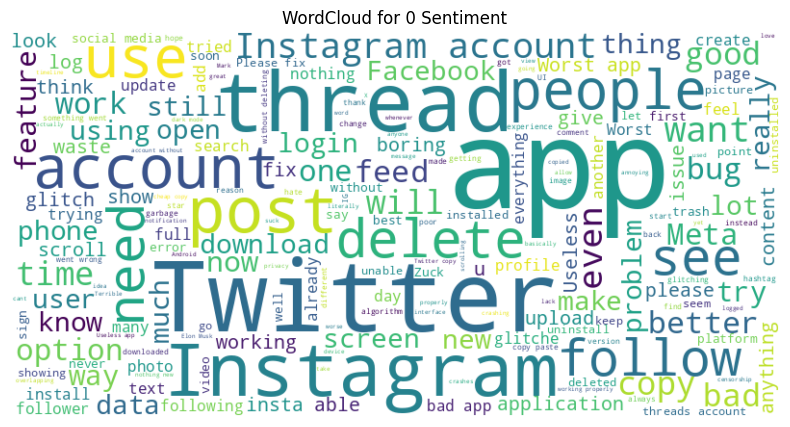

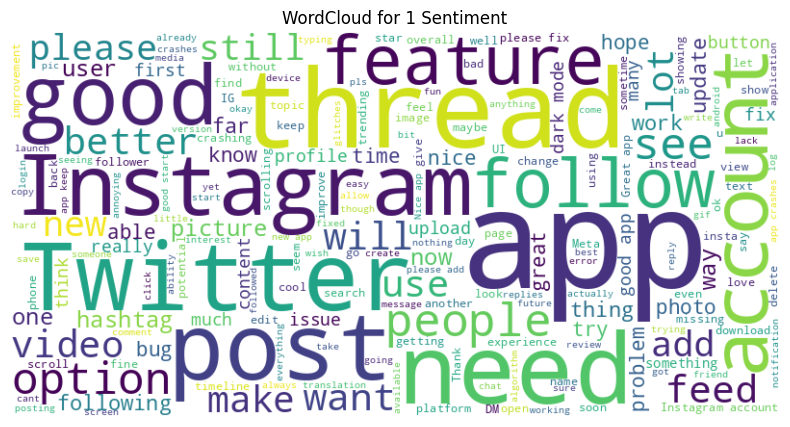

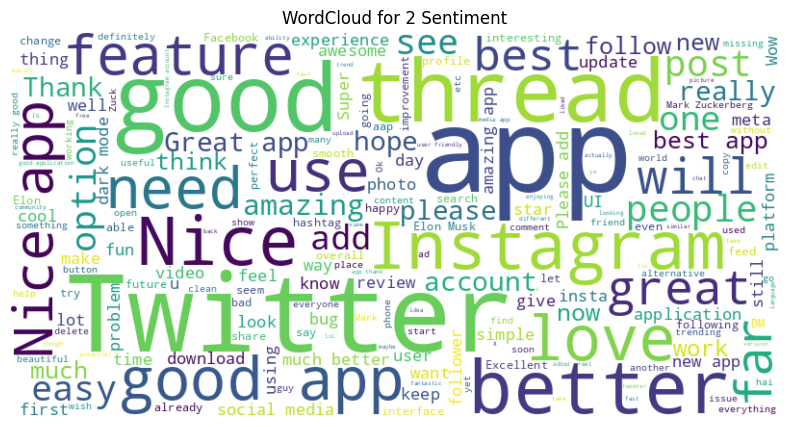

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fungsi untuk membuat dan menampilkan WordCloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Membuat WordCloud untuk setiap label
for label in df['label'].unique():
    text_for_label = " ".join(df[df['label'] == label]['content'])
    generate_wordcloud(text_for_label, f'WordCloud for {label} Sentiment')


### **PREPROCESSING**

In [52]:
import string
import re

# Menghapus tanda baca dan emotikon
def remove_punctuation_and_emoticons(text):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    return text_no_emoticons

# Mengubah menjadi huruf kecil
df['content'] = df['content'].apply(lambda x: remove_punctuation_and_emoticons(x.lower()))
# Menampilkan hasil
print(df.head())


                                             content  label data_type
0  i literally cant use the app it wont let me se...      0     train
1  the platform has potential but the app which i...      1     train
2  pretty good for a first launch its easy to use...      1       val
3  currently its very challenging to use its in d...      0       val
4  meh not the greatest experience on a chromeboo...      0       val


In [53]:
df.to_csv(path+'hasilreviews.clean.csv', index=None, header=True)

### **TRAINING/VALIDATION SPLIT**

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
# Membagi dataset menjadi data training dan data validasi

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.30,
                                                  random_state=17,
                                                  stratify=df.label.values)

In [56]:
# Menambah kolom baru "data_type"

df['data_type'] = ['not_set']*df.shape[0]

In [57]:
# Mengelompokkan nilai kolom 'data_type' di baris yang sesuai dengan indeks X_train dan X_val pada DataFrame

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [58]:
# Mengelompokkan kolom dan menghitung jumlah masing-masing kelompok

df.groupby(['label','data_type']).count()

content
label data_type         
0     train        11407
      val           4889
1     train         2202
      val            944
2     train        10518
      val           4508

### **Loading Tokenizer and Encoding our Data**

In [27]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.5 MB/s eta 0:00:00


In [64]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [61]:
# Menginisialisasi tokenizer menggunakan model BERT dengan versi dasar dan versi huruf kecil ('uncased')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [67]:
import torch

# Menggunakan tokenizer untuk mengkodekan data pelatihan
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data validasi
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids'] # Mendapatkan input_ids dari data pelatihan yang telah dienkripsi
attention_masks_train = encoded_data_train['attention_mask'] # Mendapatkan attention_masks dari data pelatihan yang telah dienkripsi
labels_train = torch.tensor(df[df.data_type=='train'].label.values) # Mengambil label untuk data pelatihan dan mengonversinya menjadi tensor PyTorch

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [68]:
# Membuat objek TensorDataset dari fitur dan label yang telah diekstraksi sebelumnya dari data pelatihan dan validasi.

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [70]:
len(dataset_train)

24127

In [71]:
len(dataset_val)

10341

### **SETTING UP BERT PRE-TRAINED MODEL**

In [72]:
from transformers import BertForSequenceClassification

In [74]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Model yang akan diunduh dan digunakan
                                                      num_labels=len(label_dict), # Menentukan jumlah label klasifikasi, Model BERT akan dikonfigurasi untuk menghasilkan output yang sesuai dengan jumlah label ini.
                                                      output_attentions=False, # Parameter opsional untuk menentukan apakah model akan mengeluarkan perhatian (attentions) selama operasi forward.
                                                      output_hidden_states=False) # Parameter opsional untuk menentukan apakah model akan mengeluarkan representasi tersembunyi (hidden states) selama operasi forward.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
# Mengeksplorasi dan mencetak informasi tentang parameter-parameter (bobot dan bias) dalam model BERT.

params = list(model.named_parameters()) # Mendapatkan Daftar Nama Parameter

print('The BERT model has {:} different named parameters.\n'.format(len(params))) # Mencetak Jumlah Parameter

print('=== Embedding Layer ===\n') # Mencetak informasi tentang parameter di lapisan embedding.
for p in params[0:5]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n=== First Transformer ===\n') #  Mencetak informasi tentang parameter di lapisan transformer pertama.
for p in params[5:21]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n=== Output Layer ===\n') # Mencetak informasi tentang parameter di lapisan output.
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

=== First Transformer ===

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,

### **CREATING DATA LOADERS**
membuat objek DataLoader untuk mengatur data pelatihan dan validasi dalam bentuk batch.

In [77]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [78]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, # Dataset PyTorch yang berisi input_ids, attention_masks, dan labels untuk data pelatihan.
                              sampler=RandomSampler(dataset_train), # Menggunakan RandomSampler untuk mengacak urutan data setiap epoch.
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                              sampler=RandomSampler(dataset_val),
                              batch_size=batch_size)

### **SETTING UP OPTIMISER AND SCHEDULER**
mempersiapkan algoritma optimasi AdamW untuk mengoptimalkan (memperbarui) parameter-parameter model selama pelatihan.

In [79]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [81]:
optimizer = AdamW(model.parameters(), # Mendapatkan semua parameter model yang memerlukan pembaruan selama pelatihan
                  lr=1e-5, # Menentukan tingkat pembelajaran (learning rate) untuk optimizer.
                  eps=1e-8) # Menentukan epsilon (ε) atau nilai kecil yang digunakan untuk mencegah pembagian dengan nol dalam algoritma AdamW.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [84]:
# membuat objek penjadwalan (scheduler) untuk mengatur tingkat pembelajaran (learning rate) selama pelatihan model.

epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Menentukan jumlah langkah "warmup" di awal pelatihan
                                            num_training_steps=len(dataloader_train)*epochs) #Menentukan total langkah pelatihan yang akan dijalani oleh model.

### **DEFINING OUR PERFORMANCE METRICS**

In [86]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [89]:
# Mengukur kualitas keseluruhan dari model klasifikasi. F1 Score adalah ukuran gabungan dari presisi dan recall.
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted') # memberikan bobot lebih besar pada kelas-kelas dengan jumlah sampel yang lebih besar.

# Mengukur presisi model, yaitu kemampuan model untuk tidak memberi label positif pada sampel yang seharusnya negatif.
def precision_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return precision_score(labels_flat, preds_flat, average='macro') # menghitung presisi secara rata-rata pada semua kelas tanpa memperhitungkan ketidakseimbangan kelas.

# Mengukur akurasi keseluruhan dari model, yaitu sejauh mana model dapat memprediksi dengan benar.
def accuracy_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return accuracy_score(labels_flat, preds_flat, average='weighted') # untuk memberikan bobot lebih besar pada kelas-kelas dengan jumlah sampel yang lebih besar.

In [91]:
def accuracy_per_class(preds, labels): # menghitung akurasi per kelas pada model klasifikasi
  label_dict_inverse = {v: k for k, v in label_dict.items()} # # Mengembalikan kamus invers dari kamus label_dict

# Mengambil prediksi dan label dalam bentuk flat array
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels.flat): # Iterasi melalui setiap label unik dalam labels
# Mengambil prediksi dan label yang sesuai dengan label saat ini
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
 # Mencetak akurasi per kelas
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

### **CREATING OUR TRAINING LOOP**

In [92]:
# Menentukan perangkat yang digunakan untuk melatih atau menggunakan model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [93]:
# Mengevaluasi model pada set data validasi.

def evaluate(dataloader_val):

  model.eval()

 # Inisialisasi variabel untuk menghitung total kerugian, prediksi, dan nilai sebenarnya
  loss_val_total = 0
  predictions, true_vals = [], []

# Iterasi melalui batch dalam dataloader validasi
  for batch in dataloader_val:

# Memindahkan batch ke perangkat yang ditentukan (GPU atau CPU)
    batch = tuple(b.to(device) for b in batch)

# Membuat dictionary inputs untuk diberikan ke model
    inputs = {'inputs_ids':     batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
              }

# Evaluasi model tanpa perhitungan gradien
    with torch.no_grad():
      outputs = model(**inputs)

# Mendapatkan kerugian dan logits dari output model
    loss = outputs[0]
    logits = outputs[1]
    loss_val_total += loss.item()

# Mengonversi logits dan label ke dalam bentuk numpy array
    logits = logits.detach().cpu().numpy()
    labels_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(labels_ids)

# Menghitung rata-rata kerugian untuk set data validasi
  loss_val_avg = loss_val_total/len(dataloader_val)

# Menggabungkan prediksi dan nilai sebenarnya ke dalam array numpy
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return loss_val_avg, predictions, true_vals

In [97]:
! pip install tqdm

In [ ]:
from transformers.pipelines.image_segmentation import Predictions
from tqdm import tqdm

for epoch_i in tqdm(range(0, epochs)):

  model.train()

  loss_train_total = 0

  progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch_i+1), leave=True, disable=False)
  for batch in progress_bar:

    model.zero_grad()

    batch = tuple(b.to(device) for b in batch)

    inputs = {'input_ids' :     batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
              }

    outputs = model(**inputs)

    loss = outputs[0]
    loss_train_total += loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    progress_bar.set_postfix({'training_loss': '{0:.2f}'.format(loss.item()/len(batch))})

  torch.save(model.state_dict(), f'finatuned_BERT_epoch_{epoch_i}.model')

  tqdm.write(f'\nEpoch {epoch_i}')

  loss_train_avg = loss_train_total/len(dataloader_train)
  tqdm.write(f'Training loss: {loss_train_avg}')

  val_loss, predictions, true_vals = evaluate(dataloader_validation)
  val_f1 = f1_score_func(predictions, true_vals)
  val_precision = precision_score_func(predictions, true_vals)
  val_recall = recall_score_func(predictions, true_vals)
  val_accuracy = accuracy_score_func(predictions, true_vals)
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'F1 Score (Weighted): {val_f1}')
  tqdm.write(f'Precision Score: {val_precision}')
  tqdm.write(f'Recall Score: {val_recall}')
  tqdm.write(f'Accuracy Score: {val_accuracy}')

  training_status.append(
      {
          'epoch' : epoch_i + 1,
          'Training Loss': loss_train_avg,
          'Valid. Loss': val_loss,
          'FI Score': val_f1,
          'Precision Score': val_precision,
          'Recall Score': val_recall,
          'Accuracy Score':val_accuracy
      }
  )

Epoch 1:   0%|          | 1/754 [02:01<25:27:28, 121.71s/it, training_loss=0.37]